In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import timeit

from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, Activation, Flatten, SimpleRNN
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#LOAD DATA
df = pd.read_csv('https://raw.githubusercontent.com/azharabiman/azharabiman/main/ERA-5%20Stasiun%20Meteorologi%20Maritim%20Tanjung%20Perak%20Temperature%20Interpolation%20Linear.csv')
df

,time,t2m,skt
0,2016-01-01 07:00:00,27.408979,28.876314
1,2016-01-01 08:00:00,27.517393,31.213698
2,2016-01-01 09:00:00,30.413400,32.685822
3,2016-01-01 10:00:00,30.736867,34.042578
4,2016-01-01 11:00:00,30.970796,34.745018
...,...,...,...
48931,2021-08-01 02:00:00,26.803786,25.307974
48932,2021-08-01 03:00:00,25.526050,25.223931
48933,2021-08-01 04:00:00,25.402181,24.811574
48934,2021-08-01 05:00:00,25.459933,24.788908


In [ ]:
#DATA DESCRIPTION
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time').resample("H").mean()
df

,t2m,skt
time,,
2016-01-01 07:00:00,27.408979,28.876314
2016-01-01 08:00:00,27.517393,31.213698
2016-01-01 09:00:00,30.413400,32.685822
2016-01-01 10:00:00,30.736867,34.042578
2016-01-01 11:00:00,30.970796,34.745018
...,...,...
2021-08-01 02:00:00,26.803786,25.307974
2021-08-01 03:00:00,25.526050,25.223931
2021-08-01 04:00:00,25.402181,24.811574


In [ ]:
df = df.loc[:,['t2m']]
print('Total num of missing values: ', df['t2m'].isna().sum())

Total num of missing values:  0


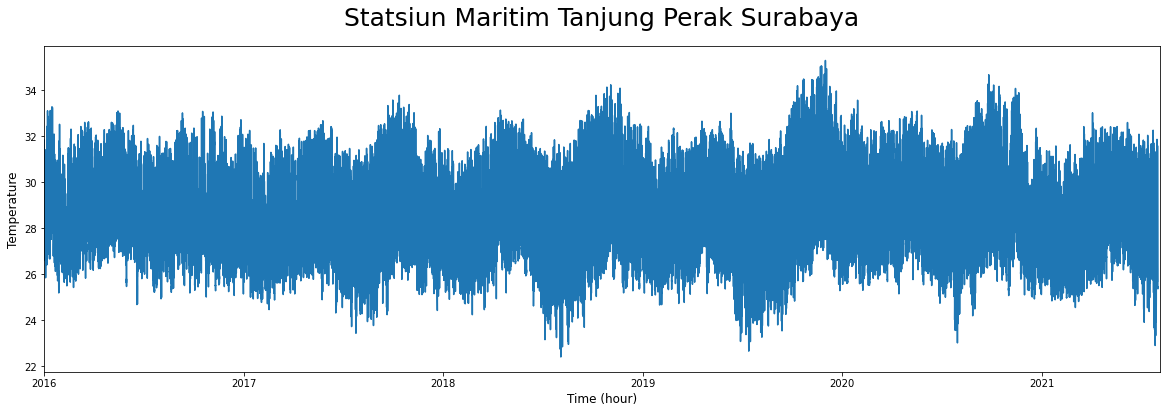

In [ ]:
def timeseries (x_axis, y_axis, x_label):
  plt.figure(figsize = (20, 6))
  plt.plot(x_axis, y_axis)
  plt.xlabel(x_label, {'fontsize': 12}) 
  plt.ylabel('Temperature', {'fontsize': 12})
  plt.title('Statsiun Maritim Tanjung Perak Surabaya',pad=20, fontdict={'fontsize':25})
  start = pd.to_datetime(['2016-01-01'])
  end = pd.to_datetime(['2021-08-05'])
  plt.xlim(start,end)

dataset = df.copy()
timeseries(df.index, dataset['t2m'], 'Time (hour)')


**PRE-PROCESSING DATA**

In [ ]:
train_size = int(len(df)*0.8)
data_train = df.iloc[:train_size]
data_test = df.iloc[train_size:]
print('Data train: ', data_train.shape)
print('Data test: ', data_test.shape)

Data train:  (39148, 1)
Data test:  (9788, 1)


(array([735964.]), array([738007.]))

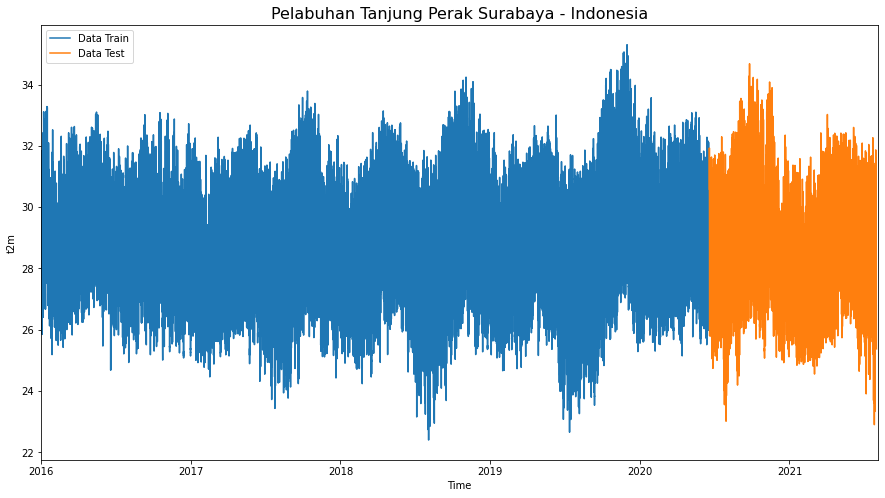

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Pelabuhan Tanjung Perak Surabaya - Indonesia", fontsize=16)
plt.plot(data_train['t2m'])
plt.plot(data_test['t2m'])
plt.xlabel('Time')
plt.ylabel('t2m')
plt.legend(['Data Train', 'Data Test'], loc='upper left')
start = pd.to_datetime(['2016-01-01'])
end = pd.to_datetime(['2021-08-05'])
plt.xlim(start,end)

In [ ]:
data_test

,t2m
time,
2020-06-19 11:00:00,30.589709
2020-06-19 12:00:00,31.552030
2020-06-19 13:00:00,31.829567
2020-06-19 14:00:00,31.932520
2020-06-19 15:00:00,31.344508
...,...
2021-08-01 02:00:00,26.803786
2021-08-01 03:00:00,25.526050
2021-08-01 04:00:00,25.402181


In [ ]:
scaler = MinMaxScaler().fit(data_train)
scaled_train = scaler.transform(data_train)
scaled_test = scaler.transform(data_test)
scaled_train

array([[0.38818754],
       [0.39658614],
       [0.62093301],
       ...,
       [0.3791056 ],
       [0.60477751],
       [0.61427799]])

In [ ]:
scaled_test

array([[0.63459128],
       [0.70914003],
       [0.73064023],
       ...,
       [0.23272552],
       [0.23719948],
       [0.23062599]])

In [ ]:
def create_dataset(X, look_back):
  Xs, Ys = [], []

  for i in range(len(X)-look_back):
    v = X[i:i+look_back]
    Xs.append(v)
    Ys.append(X[i+look_back])

  return np.array(Xs), np.array(Ys)

X_train, Y_train = create_dataset(scaled_train, 24)
X_test, Y_test = create_dataset(scaled_test, 24)

print('X Train Shape: ', X_train.shape)
print('Y Train Shape: ', Y_train.shape)
print('X Test shape: ', X_test.shape)
print('Y Test Shape: ', Y_test.shape)

X Train Shape:  (39124, 24, 1)
Y Train Shape:  (39124, 1)
X Test shape:  (9764, 24, 1)
Y Test Shape:  (9764, 1)


In [ ]:
X_train

array([[[0.38818754],
        [0.39658614],
        [0.62093301],
        ...,
        [0.35817759],
        [0.39518085],
        [0.40320248]],

       [[0.39658614],
        [0.62093301],
        [0.64599128],
        ...,
        [0.39518085],
        [0.40320248],
        [0.41052383]],

       [[0.62093301],
        [0.64599128],
        [0.66411324],
        ...,
        [0.40320248],
        [0.41052383],
        [0.40806838]],

       ...,

       [[0.38957331],
        [0.62926173],
        [0.64770036],
        ...,
        [0.34852082],
        [0.34955462],
        [0.35945747]],

       [[0.62926173],
        [0.64770036],
        [0.66797965],
        ...,
        [0.34955462],
        [0.35945747],
        [0.3791056 ]],

       [[0.64770036],
        [0.66797965],
        [0.72375246],
        ...,
        [0.35945747],
        [0.3791056 ],
        [0.60477751]]])

In [ ]:
Y_train

array([[0.41052383],
       [0.40806838],
       [0.57228975],
       ...,
       [0.3791056 ],
       [0.60477751],
       [0.61427799]])

In [ ]:
#RNN MODEL
def method_RNN(units):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.SimpleRNN(units, activation= 'tanh', return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(tf.keras.layers.SimpleRNN(units, activation= 'tanh', return_sequences=False))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(1))

    optimizer = tf.keras.optimizers.Adam(1e-3)
    #model_RNN.compile(loss="mse", optimizer=optimizer)
    model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mse"])
    
    return model
model_RNN = method_RNN(64)

In [ ]:
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24, 64)            4224      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 12,545
Trainable params: 12,545
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Conv RNN Model
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

def method_ConvRNN(units):
    #model ConvRNN
    model = tf.keras.models.Sequential()
    model.add(Conv1D(units, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=[X_train.shape[1],X_train.shape[2]]))
    model.add(MaxPooling1D(2))
    model.add(tf.keras.layers.SimpleRNN(units, activation= 'tanh'))
    #model.add(tf.keras.layers.SimpleRNN(units, activation= 'tanh', return_sequences=False))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(1))

    #model learning rate using Adam optimization
    optimizer = tf.keras.optimizers.Adam(1e-3)

    #model loss calculation using mse
    model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mse"])

    return model
model_ConvRNN = method_ConvRNN(128)

In [ ]:
model_ConvRNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 128)           512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 128)          0         
 )                                                               
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                      

In [ ]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    history = model.fit(X_train, Y_train, epochs = 50, batch_size = 32, validation_split = 0.2, shuffle = False, callbacks = [early_stop])
    return history
    

In [ ]:
history_RNN = fit_model(model_RNN)

Epoch 1/50
979/979 [==============================] - 53s 47ms/step - loss: 0.0056 - mse: 0.0112 - val_loss: 0.0023 - val_mse: 0.0045
Epoch 2/50
979/979 [==============================] - 41s 42ms/step - loss: 0.0013 - mse: 0.0025 - val_loss: 0.0011 - val_mse: 0.0023
Epoch 3/50
979/979 [==============================] - 41s 42ms/step - loss: 0.0011 - mse: 0.0021 - val_loss: 0.0012 - val_mse: 0.0024
Epoch 4/50
979/979 [==============================] - 40s 40ms/step - loss: 0.0010 - mse: 0.0020 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 5/50
979/979 [==============================] - 39s 40ms/step - loss: 9.3812e-04 - mse: 0.0019 - val_loss: 0.0011 - val_mse: 0.0022
Epoch 6/50
979/979 [==============================] - 39s 39ms/step - loss: 9.2036e-04 - mse: 0.0018 - val_loss: 9.2159e-04 - val_mse: 0.0018
Epoch 7/50
979/979 [==============================] - 40s 40ms/step - loss: 8.7783e-04 - mse: 0.0018 - val_loss: 9.9638e-04 - val_mse: 0.0020
Epoch 8/50
979/979 [======================

In [ ]:
history_ConvRNN = fit_model(model_ConvRNN)

Epoch 1/50
979/979 [==============================] - 25s 16ms/step - loss: 0.0015 - mse: 0.0030 - val_loss: 0.0014 - val_mse: 0.0028
Epoch 2/50
979/979 [==============================] - 14s 14ms/step - loss: 8.7885e-04 - mse: 0.0018 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 3/50
979/979 [==============================] - 14s 14ms/step - loss: 8.2258e-04 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0032
Epoch 4/50
979/979 [==============================] - 14s 15ms/step - loss: 7.6632e-04 - mse: 0.0015 - val_loss: 8.5752e-04 - val_mse: 0.0017
Epoch 5/50
979/979 [==============================] - 14s 14ms/step - loss: 7.5906e-04 - mse: 0.0015 - val_loss: 0.0012 - val_mse: 0.0023
Epoch 6/50
979/979 [==============================] - 14s 15ms/step - loss: 7.3942e-04 - mse: 0.0015 - val_loss: 0.0010 - val_mse: 0.0021
Epoch 7/50
979/979 [==============================] - 15s 15ms/step - loss: 7.2214e-04 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0028
Epoch 8/50
979/979 [==============

**PREDICTION**

In [ ]:
Y_test = scaler.inverse_transform(Y_test)
Y_train = scaler.inverse_transform(Y_train)

def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_RNN = prediction(model_RNN)
prediction_ConvRNN = prediction(model_ConvRNN)


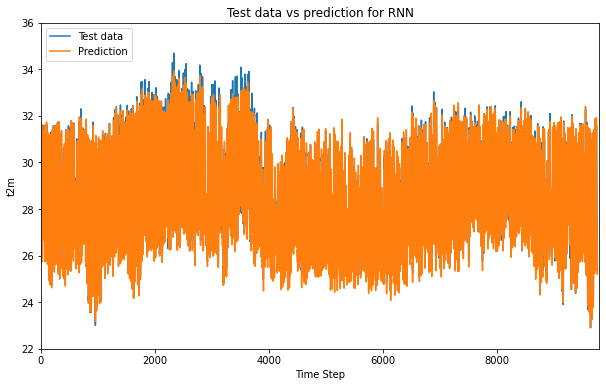

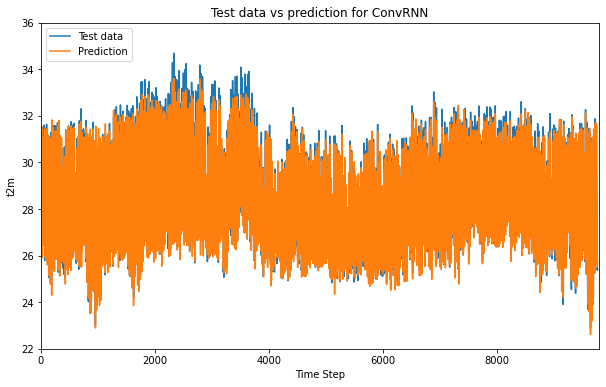

In [ ]:
def plot_future(prediction, y_test, model_name):    
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time Step')
    plt.ylabel('t2m')
    plt.xlim(0,9790)
    plt.ylim(22,36)
    

plot_future(prediction_RNN, Y_test, 'RNN')
plot_future(prediction_ConvRNN, Y_test, 'ConvRNN')



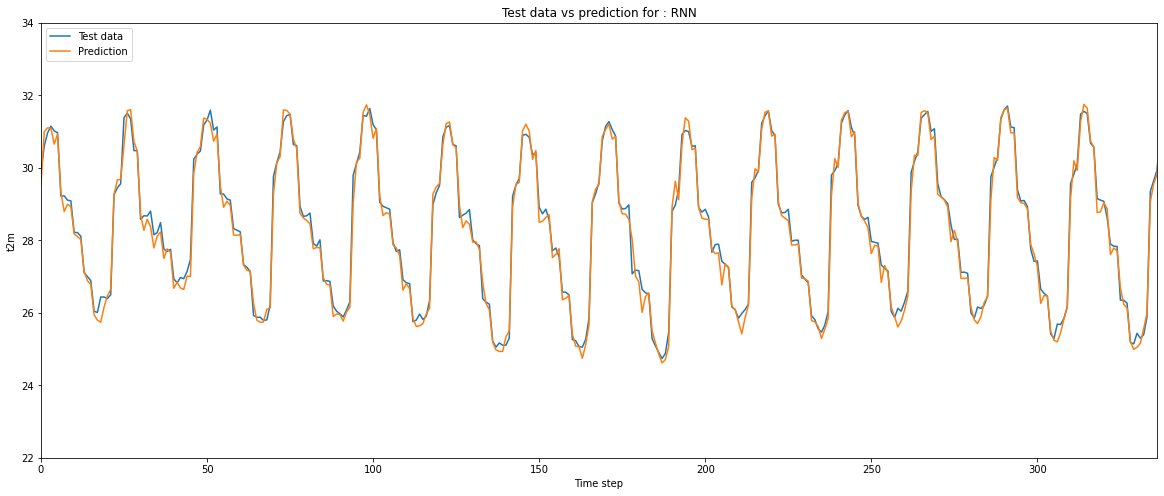

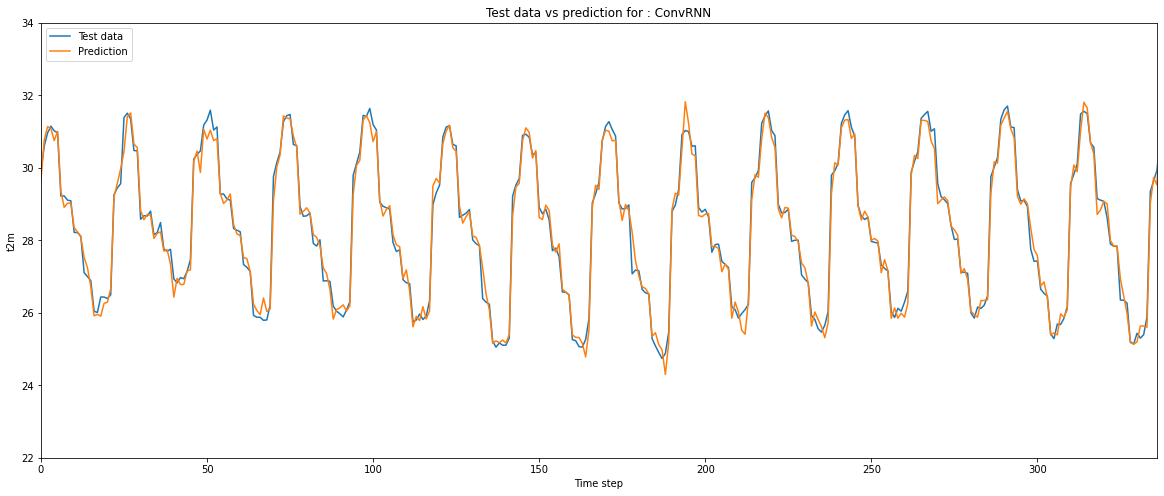

In [ ]:
def plot_future_zoom(prediction, y_test, name, zoom):
    month = 24*zoom 
    plt.figure(figsize=(20, 8))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for : ' + name)
    plt.legend(loc='upper left')
    plt.xlabel('Time step')
    plt.ylabel('t2m')
    plt.xlim(0,month)
    plt.ylim(22,34)

plot_future_zoom(prediction_RNN, Y_test, 'RNN',14)
plot_future_zoom(prediction_ConvRNN, Y_test, 'ConvRNN',14)

**ERROR CHECK**

In [ ]:
import scipy
from scipy.stats import pearsonr
# MAE RMSE CC

def evaluate_prediction(predictions, actual, model_name):
    scaled_pred = scaler.transform(predictions)
    scaled_actu = scaler.transform(actual)
  
    errors = scaled_pred - scaled_actu
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    scaled_actu = np.squeeze(scaled_actu)
    scaled_pred = np.squeeze(scaled_pred)
    cc = scipy.stats.pearsonr(scaled_actu,scaled_pred)[0]
    # Using spearman's correlation
    #corr,_ = spearmanr(scaled_pred, scaled_actu)

    print(model_name)
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Correlation Coefficient: {:.4f}'.format(cc))
    print('')

evaluate_prediction(prediction_RNN, Y_test, 'RNN')
evaluate_prediction(prediction_ConvRNN, Y_test, 'ConvRNN')


RNN
Mean Absolute Error: 0.0221
Root Mean Square Error: 0.0324
Correlation Coefficient: 0.9811

ConvRNN
Mean Absolute Error: 0.0265
Root Mean Square Error: 0.0365
Correlation Coefficient: 0.9754



##Uji Skenario


In [ ]:
#skenario pengujian
test_data3 = df['2021-07-04':'2021-07-06'] #3 days = 72jam
test_data7 = df['2021-07-04':'2021-07-10'] #7 days = 168 jam
test_data14 = df['2021-07-04':'2021-07-17'] #14 days = 336 jam
test_data28 = df['2021-07-04':'2021-07-31'] #28 days = 672 jam

test_scaled3 = scaler.transform(test_data3)
test_scaled7 = scaler.transform(test_data7)
test_scaled14 = scaler.transform(test_data14)
test_scaled28 = scaler.transform(test_data28)

#lookback
X_test_3, y_test_3 = create_dataset(test_scaled3,24)
X_test_7, y_test_7 = create_dataset(test_scaled7,24)
X_test_14, y_test_14 = create_dataset(test_scaled14,24)
X_test_28, y_test_28 = create_dataset(test_scaled28,24)


#X_test, y_test = create_dataset(test_scaled,36)
#X_test, y_test = create_dataset(test_scaled,48)

print('X_test_3.shape: ', X_test_3.shape) 
print('y_test_3.shape: ', y_test_3.shape)



X_test_3.shape:  (48, 24, 1)
y_test_3.shape:  (48, 1)


In [ ]:
# Select hour of data from test data
new_data3 = test_data3
new_data7 = test_data7
new_data14 = test_data14
new_data28 = test_data28

# Scale the input
scaled_data3 = scaler.transform(new_data3)
scaled_data7 = scaler.transform(new_data7)
scaled_data14 = scaler.transform(new_data14)
scaled_data28 = scaler.transform(new_data28)

# Reshape the input 
def create_dataset (X, look_back = 1):
    Xs = []
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        
    return np.array(Xs)

X_new3= create_dataset(scaled_data3,24)
X_new7= create_dataset(scaled_data7,24)
X_new14= create_dataset(scaled_data14,24)
X_new28= create_dataset(scaled_data28,24)
print('X_new.shape: ', X_new7.shape) 

X_new.shape:  (144, 24, 1)


In [ ]:
# Make prediction for new data
def prediction(model, X_n):
    prediction = model.predict(X_n)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction1_RNN = prediction(model_RNN,X_new3)
prediction1_ConvRNN = prediction(model_ConvRNN,X_new3)

prediction2_RNN = prediction(model_RNN,X_new7)
prediction2_ConvRNN = prediction(model_ConvRNN,X_new7)

prediction3_RNN = prediction(model_RNN,X_new14)
prediction3_ConvRNN = prediction(model_ConvRNN,X_new14)

prediction4_RNN = prediction(model_RNN,X_new28)
prediction4_ConvRNN = prediction(model_ConvRNN,X_new28)

# Plot history and future
def plot_multi_step(history, prediction1, prediction2, x_start, x_end):
    
    plt.figure(figsize=(15, 6))
    
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))

    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with RNN', color = ('red') )
    plt.plot(range_future, np.array(prediction2),label='Forecasted with ConvRNN', color = ('green') )
    
    plt.legend(loc='upper right')
    plt.xlabel('Time step (hour)')
    plt.ylabel('t2m (m)')
    plt.xlim(x_start,x_end)
   

In [ ]:
def eval(predictions, actual, name):
    pred = scaler.transform(predictions)

    errors = (pred - actual)
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    # Using spearman's correlation
    #corr, _ = spearmanr(scaled_pred, scaled_actu)
    actual = np.squeeze(actual)
    pred = np.squeeze(pred)
    cc = scipy.stats.pearsonr(actual,pred)[0]

    print('Model name :' + name)
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Correlation Coefficient: {:.4f}'.format(cc))
    print('')

Model name :RNN
Mean Absolute Error: 0.0122
Root Mean Square Error: 0.0158
Correlation Coefficient: 0.9957

Model name :ConvRNN
Mean Absolute Error: 0.0209
Root Mean Square Error: 0.0268
Correlation Coefficient: 0.9881



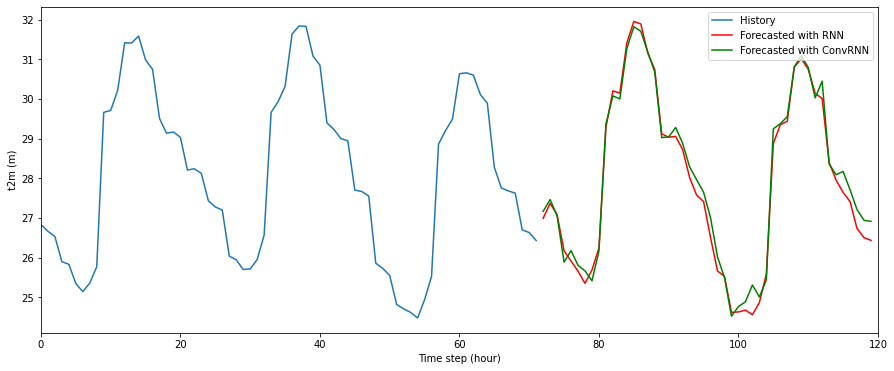

In [ ]:
plot_multi_step(new_data3, prediction1_RNN, prediction1_ConvRNN,0,120)
eval(prediction1_RNN, y_test_3, 'RNN')
eval(prediction1_ConvRNN, y_test_3, 'ConvRNN')

Model name :RNN
Mean Absolute Error: 0.0163
Root Mean Square Error: 0.0234
Correlation Coefficient: 0.9899

Model name :ConvRNN
Mean Absolute Error: 0.0212
Root Mean Square Error: 0.0277
Correlation Coefficient: 0.9844



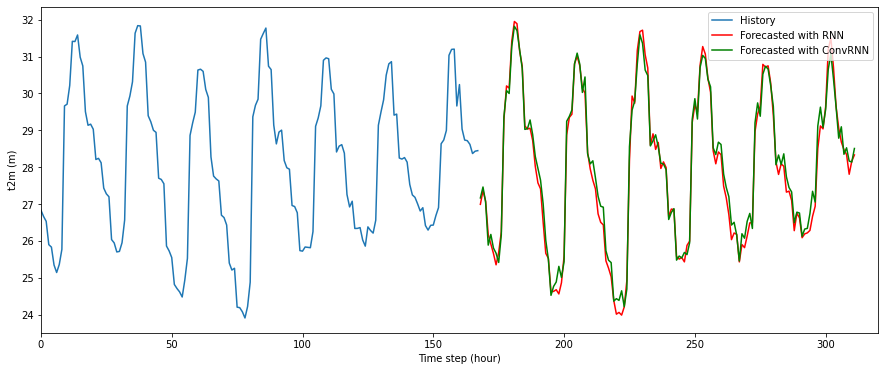

In [ ]:
plot_multi_step(new_data7, prediction2_RNN, prediction2_ConvRNN,0,320)
eval(prediction2_RNN, y_test_7, 'RNN')
eval(prediction2_ConvRNN, y_test_7, 'ConvRNN')

Model name :RNN
Mean Absolute Error: 0.0159
Root Mean Square Error: 0.0229
Correlation Coefficient: 0.9903

Model name :ConvRNN
Mean Absolute Error: 0.0216
Root Mean Square Error: 0.0282
Correlation Coefficient: 0.9845



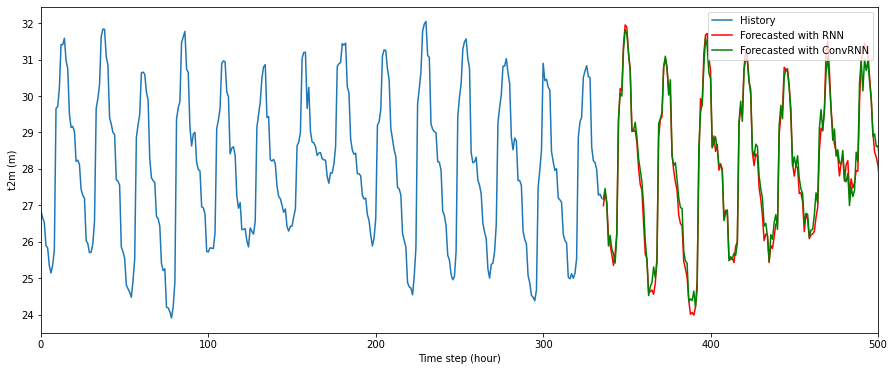

In [ ]:
plot_multi_step(new_data14, prediction3_RNN, prediction3_ConvRNN,0,500)
eval(prediction3_RNN, y_test_14, 'RNN')
eval(prediction3_ConvRNN, y_test_14, 'ConvRNN')

Model name :RNN
Mean Absolute Error: 0.0154
Root Mean Square Error: 0.0214
Correlation Coefficient: 0.9925

Model name :ConvRNN
Mean Absolute Error: 0.0203
Root Mean Square Error: 0.0260
Correlation Coefficient: 0.9885



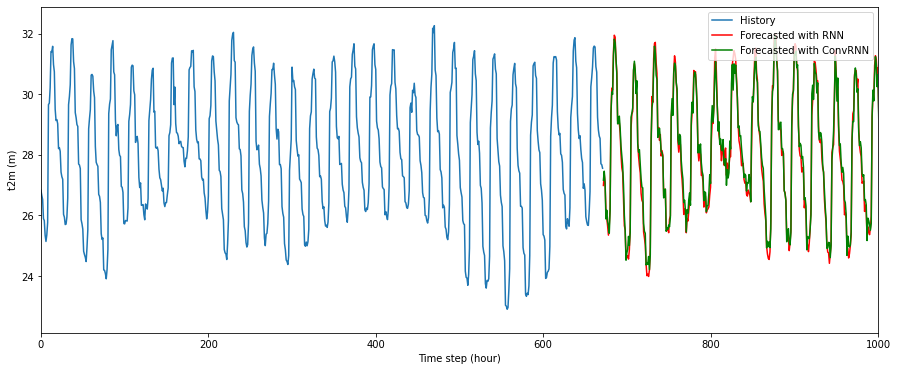

In [ ]:
plot_multi_step(new_data28, prediction4_RNN, prediction4_ConvRNN,0,1000)
eval(prediction4_RNN, y_test_28, 'RNN')
eval(prediction4_ConvRNN, y_test_28, 'ConvRNN')